Install prerequisites

In [ ]:
# !pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0+cpu.html
# !pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0+cpu.html
# !pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.11.0+cpu.html
# !pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.11.0+cpu.html
# !pip install torch-geometric
# !pip install umap
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 6.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 407 kB 6.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=5b5ebe1edd6a73d61b54422219779c1a2a366cca2eac322809cdb9b6f51223a8
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


# Constants and modules

In [ ]:
""" WRSN settings """
# K = 50 # Number of charging locations
INFTY = 999999
RANDOM_CHARGING_TIME = 50
STATUS = {'LIVE': 1, 'DEAD': 0}
BASE_INDEX = -1
E_MIN = 540
E_MAX = 10800
ALPHA = 3600
BETA = 30
E_MC = 108000
P = 5
V = 5
E = 100 # Charging rate of MC
ENERGY_STATE = 1000 # Number of states for energy of sensors
PENALTY_PARAMETER_1 = 0.1 # Use for sum of energy of sensors
PENALTY_PARAMETER_2 = 0.5 # Uses for penalize energy of MC, prevents from heading back to depot unnecessary
E_THRESHOLD = 10000
T = 200000
REWARDS = []
LOSS_VALUES = []
RECORDED_DEAD_NODES = None
END_EPISODE = [0]
""" DQN and training phase settings """
BATCH_SIZE = 50
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

""" For state graph """
DELTA = 40
LOSS_THRESHOLD = 0.2


Import modules

In [ ]:
import math
import pickle
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from collections import namedtuple, deque
from itertools import count

Global variables

In [ ]:
# For training agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For training GraphSAGE
model = None
optimizer = None
graph = None

# WRSN

## Stationary

### Point

In [ ]:
class Point:
    """
    create a Point class, which is an abstraction of a deployed position in real world
    :arg pos_x, x position in the FoI
    :arg pos_y, y position in the FoI
    """

    def __init__(self, pos_x, pos_y):
        self.pos = np.array([pos_x, pos_y])

    def calculate_distance_to_other_point(self, other_point):
        try:
            return np.linalg.norm(self.pos - other_point.pos)
        except Exception:
            print("Exception at Point.calculate_distance_to_other_point")
            raise


### Base station

In [ ]:
class BaseStation:
    """
    create a Base Station class, which is an abstraction of the base station in real world
    :arg pos_x, x position in the FoI
    :arg pos_y, y position in the FoI
    """

    def __init__(self, pos_x, pos_y):
        self.point = Point(pos_x, pos_y)

    def calculate_distance_to_sensor(self, sensor):
        try:
            return self.point.calculate_distance_to_other_point(sensor.point)
        except Exception:
            print("Exception at BaseStation.calculate_distance_to_sensor")
            raise

    def calculate_distance_to_charging_location(self, location):
        try:
            return self.point.calculate_distance_to_other_point(location.point)
        except Exception:
            print("Exception at BaseStation.calculate_distance_to_charging_location")
            raise


### Charging Location

In [ ]:
class ChargingLocation:
    """
    create a Charging Location class, which is an abstraction of a charging location in real world
    :arg pos_x, x position in the FoI
    :arg pos_y, y position in the FoI
    """

    def __init__(self, pos_x, pos_y):
        self.point = Point(pos_x, pos_y)
        self.sensors = []
        self.sensors_charging_rate = []

    def calculate_distance_to_sensor(self, sensor):
        try:
            return self.point.calculate_distance_to_other_point(sensor.point)
        except Exception:
            print("Exception at ChargingLocation.calculate_distance_to_sensor")
            raise

    def calculate_distance_to_charging_location(self, other_location):
        try:
            return self.point.calculate_distance_to_other_point(other_location.point)
        except Exception:
            print("Exception at ChargingLocation.calculate_distance_to_charging_location")
            raise

    def calculate_charging_rate_to_sensor(self, sensor):
        """
        calculate charging rate to a specific sensor using Friis equation
        :param sensor:
        :return: charging rate
        """
        return ALPHA / ((BETA + self.calculate_distance_to_sensor(sensor)) ** 2)


### Sensor

In [ ]:
class Sensor:
    """
    create a Sensor class, which is an abstraction of a deployed sensor in real world
    :arg pos_x, x position in the FoI
    :arg pos_y, y position in the FoI
    :arg consumption_rate: the average consumption rate of sensor
    :arg init_energy: the initial energy of sensor
    """

    def __init__(self, pos_x, pos_y, consumption_rate, init_energy):
        self.point = Point(pos_x, pos_y)
        self.consumption_rate = consumption_rate
        self.init_energy = init_energy
        self.energy = init_energy
        self.status = STATUS['LIVE']

    def calculate_distance_to_other_sensor(self, other_sensor):
        try:
            return self.point.calculate_distance_to_other_point(other_sensor.point)
        except BaseException:
            print("Exception at Sensor.calculate_distance_to_other_sensor")
            raise

    def recalculate_energy_by_consumption(self, t):
        """
        calculate the energy of this sensor after a period time
        :param t: the length of the period time
        :return: one counter as dead node
        """
        try:
            if t < 0:
              # Revert to exactly T time
              return 1 if self.status == STATUS['DEAD'] else 0
            
            assert t >= 0
            if self.energy - t * self.consumption_rate <= E_MIN:
                self.energy = E_MIN
                self.status = STATUS['DEAD']
                return 1
            else:
                self.energy -= t * self.consumption_rate
                return 0
        except Exception:
            print("Exception at Sensor.recalculate_energy_by_consumption")
            raise

    def recalculate_energy_by_charging(self, t, charging_rate):
        """
        calculate the energy of this sensor after being charged by MC at some charging location
        :param t: the time which the sensor has been charged
        :param charging_rate: the charging rate from charging location
        :return: spent charging energy
        """
        try:
            if t < 0:
              # Revert to exactly T time
              return 0
            
            assert t >= 0
            assert charging_rate >= 0
            if self.status == STATUS['DEAD']:
                # In case the sensor is dead, MC will not charge it
                return 0

            energy = self.energy
            if charging_rate >= self.consumption_rate:
                if self.energy + t * (charging_rate - self.consumption_rate) >= E_MAX:
                    self.energy = E_MAX
                    return charging_rate * (E_MAX - energy) / (charging_rate - self.consumption_rate)
                else:
                    self.energy += t * (charging_rate - self.consumption_rate)
                    return charging_rate * t
            else:
                if self.energy + t * (charging_rate - self.consumption_rate) <= E_MIN:
                    # In this case, although the sensor get charged but it is still consider as a dead node
                    self.energy = E_MIN
                    self.status = STATUS['DEAD']
                    return charging_rate * (energy - E_MIN) / (self.consumption_rate - charging_rate)
                else:
                    self.energy += t * (charging_rate - self.consumption_rate)
                    return charging_rate * t
        except Exception:
            print("Exception at Sensor.recalculate_energy_by_charging")
            raise


## Dynamic

### Network

In [ ]:
class Network:
    def __init__(self, file_name, k, pos_x=0, pos_y=0):
        """
        create an abstraction of real life WRSN
        :param file_name: file name to establish sensors data
        :param k: must pass number of charging locations
        :param pos_x: optional position x of base station
        :param pos_y: optional position y of base station
        """
        self.recorded_time = 0
        self.recorded_dead_nodes = 0
        self.recorded_dead_node_list = []
        # self.before_charging_energy_list = []
        self.base = None
        self.sensors = []
        self.charging_locations = []
        self.charging_locations_distance_matrix = []
        # Store as n x m matrix
        self.charging_locations_charging_matrix = []
        # Store as capacity list
        self.charging_locations_charging_lists = []
        self.charging_locations_distance_base = []
        self.n = None
        self.m = None

        # Setup network
        self.setup_network(file_name, k, pos_x, pos_y)

    def setup_network(self, file_name, k, pos_x=0, pos_y=0):
        """
        Setting up the network
        :param file_name: contain sensors data
        :param k: number of cluster
        :param pos_x: position x of base station
        :param pos_y: position y of base station
        :return:
        """
        print("** Setting up network **")
        self.create_base_station_data(pos_x, pos_y)
        self.create_sensor_data(file_name)
        self.recalculate_network(k)
        print("** Network is ready **")

    def recalculate_network(self, k):
        """
        recalculate network after a period of charging (a long one)
        :param k: number of cluster
        :return:
        """
        self.create_charging_location_data(k)
        self.init_matrices()
        self.recalculate_matrices()

    def create_sensor_data(self, file_name):
        """
        read data from a file to gather sensors information
        :param file_name: sensor data file name
        :return:
        """
        print("-- Setting up sensors data --")
        try:
            for sensor in SensorReader.read_sensor(file_name):
                self.sensors.append(Sensor(*sensor))
            self.n = len(self.sensors)
            print("-- Done --")
        except Exception:
            print("Error at Network.create_sensor_data")
            raise

    def create_charging_location_data(self, k):
        """
        read data from a file to gather charging locations information
        using k-means cluster
        :arg k: number of clusters
        :return:
        """
        print("-- Setting up charging locations --")
        try:
            model = KMeans(n_clusters=k, n_init=10, random_state=0, max_iter=100000)
            model.fit(X=np.array(list(map(lambda x: x.point.pos, self.sensors))),
                      sample_weight=np.array(list(map(lambda x: x.consumption_rate, self.sensors))))
            self.m = k
            for location in model.cluster_centers_:
                self.charging_locations.append(ChargingLocation(*location))
            print("-- Done --")
        except Exception:
            print("Error at Network.create_charging_location_data")
            raise

    def create_base_station_data(self, pos_x=0, pos_y=0):
        print("-- Setting up base station --")
        self.base = BaseStation(pos_x, pos_y)
        print("-- Done --")

    def init_matrices(self):
        print("-- Initializing matrices --")
        self.charging_locations_distance_matrix = [[0 for _ in range(self.m)] for __ in range(self.m)]
        self.charging_locations_charging_matrix = [[0 for _ in range(self.m)] for __ in range(self.n)]
        self.charging_locations_charging_lists = [[] for _ in range(self.m)]
        self.charging_locations_distance_base = [0 for _ in range(self.m)]
        print("-- Done --")

    def recalculate_matrices(self):
        print("-- Calculating matrices --")
        # Calculate distance matrix of charging locations
        for i in range(self.m):
            for j in range(self.m):
                self.charging_locations_distance_matrix[i][j] = self.charging_locations[
                    i].calculate_distance_to_charging_location(self.charging_locations[j])

        # Calculate distance from base station to charging locations
        for i in range(self.m):
            self.charging_locations_distance_base[i] = self.base.calculate_distance_to_charging_location(
                self.charging_locations[i])

        # Calculate charging matrix of charging locations
        for i in range(self.n):
            max_val = (0, 0)
            for j in range(self.m):
                # Compare charging rate and stores the index of charging location
                max_val = max(max_val,
                              (self.charging_locations[j].calculate_charging_rate_to_sensor(self.sensors[i]), j))
            # Sensor i only receives energy from the charging location provides the maximum charging rate
            self.charging_locations_charging_matrix[i][max_val[1]] = max_val[0]
            self.charging_locations_charging_lists[max_val[1]].append(i)
        print("-- Done --")

    def check_time_exceeds(self, time_interval):
      """
      check if the recorded time exceeds the limit
      :param time_interval: the next time_interval
      return flag, remaining_time
      """
      try:
        flag = False
        if self.recorded_time + time_interval > T:
          time_interval = T - self.recorded_time + 1
          flag = True
        return flag, time_interval
      except Exception:
        print("Exception at Network.check_time_exceeds")

    def recalculate_network_by_consumption(self, time_interval, j):
        """
        update the network after a period of time interval, consider only charging consumption
        :param time_interval: the time interval
        :return: a state encoding
        """
        global graph

        flag, time_interval = self.check_time_exceeds(time_interval)
        self.recorded_time += time_interval
        for i in range(self.n):
            if i not in self.recorded_dead_node_list:
                self.sensors[i].recalculate_energy_by_consumption(time_interval)
        self.recorded_time += time_interval
        if flag:
          # If the maximum time exceeds
          print("## WARNING: TIME EXCEEDED ##")
        # return State.create_state_encoding(feature=list(map(lambda x: x.energy /
        #        x.consumption_rate, self.sensors)) + list(map(lambda x: x.energy, 
        #        self.sensors)))
        return graph.predict(j, self.recorded_time // DELTA)
          
    def recalculate_network_episodically(self):
        """
        update the network status after a period of charging time
        :return: state encoding
        """
        dead_node_list = []
        for i in range(self.n):
            if self.sensors[i].status == STATUS['DEAD'] and i not in self.recorded_dead_node_list:
                dead_node_list.append(i)
                self.recorded_dead_node_list.append(i)
                self.recorded_dead_nodes += self.sensors[i].recalculate_energy_by_consumption(0)
        return

    def recalculate_network_by_charging(self, charging_point_index, time_interval):
        """
        update the network status after MC charges at some charging location for some time
        :param charging_point_index: index of charging point
        :param time_interval: time spent on charging
        :return: spent energy
        """
        flag, time_interval = self.check_time_exceeds(time_interval)
        self.recorded_time += time_interval
        spent_energy = 0
        for i in range(self.n):
            if i in self.charging_locations_charging_lists[charging_point_index]:
                spent_energy += self.sensors[i].recalculate_energy_by_charging(time_interval,
                                                                               self.charging_locations_charging_matrix
                                                                               [i][charging_point_index])
            else:
                self.sensors[i].recalculate_energy_by_consumption(time_interval)
        if flag:
          # If the maximum time exceeds
          print("## WARNING: TIME EXCEEDED ##")
        return spent_energy

    def recalculate_by_agent_action(self, action):
        """
        update the network by action of MC. #NOTE: we allow the mc charges sensor even if the energy of sensor belows E_MIN
        :param action: the action has been taken by MC
        :return: the energy agent needs to spend
        """
        to_index, charging_time_interval, travelling_time_interval = action.create_action_decoding()
        if to_index != BASE_INDEX:
            # If the action is not going back to the base station
            self.recalculate_network_by_consumption(travelling_time_interval, to_index)
            # self.before_charging_energy_list = g.predict(action.to_index, self.recorded_time // DELTA)
            spent_energy = self.recalculate_network_by_charging(to_index, charging_time_interval)
            return spent_energy
        else:
            # The agent is heading back to the base station, it is the end of an episode
            self.recalculate_network_by_consumption(travelling_time_interval + charging_time_interval, to_index)
            self.recalculate_network_episodically()
            return 0

    """ Two illustrated functions"""

    def plot_network(self):
        nwp = NetworkPlotter(self.sensors, self.charging_locations, self.base)
        nwp.plot_network()

    def plot_journey(self, journey):
        nwp = NetworkPlotter(self.sensors, self.charging_locations, self.base)
        nwp.plot_journey(journey)


### Agent

In [ ]:
class Agent:
    global REWARDS
    def __init__(self, network: Network):
        """
        agent in this environment is also known as mobile charger
        :param network: the environmental network considering
        """
        self.network = network
        self.current_index = BASE_INDEX
        self.energy = E_MC
        self.tabu_list = [0 for i in range(self.network.m+1)]
        self.tabu_counter = 0

    def reset_tabu_list(self):
      self.tabu_list = [0 for i in range(self.network.m+1)]
      self.tabu_counter = 0

    def index_tabu_element(self, i):
      self.tabu_list[i] = 1
      self.tabu_counter += 1
      if self.tabu_counter == self.network.m:
        self.reset_tabu_list()

    def get_state(self):
        """
        get the state encoding by network
        :return: state encoding by network
        """
        return self.network.recalculate_network_by_consumption(0, self.current_index)

    def get_objective(self):
        return Objective.create_objective_value(number_of_dead_node=self.network.recorded_dead_nodes, 
                                                state=self.get_state(), 
                                                sensors_energy_list=[self.network.sensors[i].energy for i in range(self.network.n)])

    def diffuse_action(self, action):
        """
        defuse the action encoding to the network, this action is committed
        :param action: Action taken
        :return: reward, done of action
        """
        previous_objective = self.get_objective()
        self.energy -= self.network.recalculate_by_agent_action(action)
        to_index, charging_time_interval, travelling_time_interval = action.create_action_decoding()
        self.energy -= P * travelling_time_interval
        assert self.energy > 0
        self.current_index = to_index
        if to_index == BASE_INDEX:
            # MC returns to base station
            self.energy = min(E_MC, self.energy + charging_time_interval * E)
        REWARDS.append(self.get_objective() - previous_objective)
        return self.get_objective() - previous_objective, 1 if to_index == BASE_INDEX else 0
        # return self.get_objective(), 1 if to_index == BASE_INDEX else 0
        
    def create_action(self, to_index, time_interval):
        return Action.create_action_encoding(to_index, time_interval, self.calculate_travelling_time(to_index))

    def create_policy_action(self, to_index=0, is_random=True):
        # This version is designated to fully charging
        try:
            if is_random:
                to_index = random.randint(0, self.network.m - 1)
            if to_index == BASE_INDEX:
                return self.create_action(BASE_INDEX, (E_MC - self.energy - 
                       self.calculate_travelling_time(BASE_INDEX) * P) / E)

            charging_time_interval = RANDOM_CHARGING_TIME
            for i in self.network.charging_locations_charging_lists[to_index]:
                if self.network.charging_locations_charging_matrix[i][to_index] > self.network.sensors[
                    i].consumption_rate:
                    # Estimate charging time for sensor i
                    charging_time_interval = max(charging_time_interval, (E_MAX 
                                                 - self.network.sensors[i].energy + self.network.sensors[i].consumption_rate * self.calculate_travelling_time(to_index)) /
                                                 (self.network.charging_locations_charging_matrix[i][to_index] -
                                                  self.network.sensors[i].consumption_rate))
            estimate_energy = 0
            for i in self.network.charging_locations_charging_lists[to_index]:
                estimate_energy += charging_time_interval * self.network.charging_locations_charging_matrix[i][to_index]
            if self.energy < 1000 + estimate_energy + P * self.network.charging_locations_distance_matrix[self.current_index][to_index] / V:
              return self.create_action(BASE_INDEX, (E_MC - self.energy - 
                       self.calculate_travelling_time(BASE_INDEX) * P) / E)

            print("++ Charging time spent at {} is {} ++".format(to_index, charging_time_interval))
            print("++ Energy left of MC is {} ++\n".format(self.energy))
            return self.create_action(to_index, charging_time_interval)
        except Exception:
            print("Error at Agent.create_policy_action")
            raise

    def calculate_travelling_time(self, to_index):
        """
        calculate the time for travelling to the next index
        :param to_index:
        :return:
        """
        if self.current_index == BASE_INDEX:
            return self.network.charging_locations_distance_base[to_index] / V
        if to_index == BASE_INDEX:
            return self.network.charging_locations_distance_base[self.current_index] / V
        else:
            return self.network.charging_locations_distance_matrix[self.current_index][to_index] / V


### Action

In [ ]:
class Action:
    def __init__(self, to_index, charging_time_interval, travelling_time_interval):
        """
        an encoding action
        :param to_index: the next index
        :param charging_time_interval: the charging time spent
        :param travelling_time_interval: the travelling time spent
        """
        self.to_index = to_index
        self.charging_time_interval = charging_time_interval
        self.travelling_time_interval = travelling_time_interval

    @staticmethod
    def create_action_encoding(to_index, charging_time_interval, travelling_time_interval):
        return Action(to_index, charging_time_interval, travelling_time_interval)

    def create_action_decoding(self):
        return self.to_index, self.charging_time_interval, self.travelling_time_interval

    @staticmethod
    def calculate_action_size(agent) -> int:
        try:
            return agent.network.m
        except Exception:
            print("Error at Action.calculate_action_size")
            raise


### State

In [ ]:
class State:
    @staticmethod
    def create_state_encoding(**kwargs):
        try:
            sensors_energy_list = kwargs['feature']
            return torch.FloatTensor(list(map(lambda x: 
                                              x, sensors_energy_list))).to(device)
        except Exception:
            print("Error at State.create_state_encoding")
            raise


### Objective

In [ ]:
class Objective:
    @staticmethod
    def create_objective_value(**kwargs):
        try:
            number_of_dead_nodes = kwargs['number_of_dead_node']
            state = kwargs['state']
            sensors_energy_list = kwargs['sensors_energy_list']
            temp = list(filter(lambda x: x > E_MIN, sensors_energy_list))
            return min(temp) / max(temp)
        except Exception:
            print("Error at Objective.create_objective_value")
            raise


## Util

### Base Reader

In [ ]:
class BaseReader:
    def __init__(self, file_name):
        """
        :param file_name: (String) File name of input data
        """
        self.file_name = file_name

    @staticmethod
    def read(file_name):
        try:
            f = open(file_name)
            data = f.readlines()
            for data_line in data:
                yield tuple(map(float, data_line.strip().split(" ")))
            f.close()
        except Exception:
            print("Exception at BaseReader.read")
            raise


### Sensor Reader

In [ ]:
class SensorReader(BaseReader):
    def __init__(self, file_name):
        super(SensorReader, self).__init__(file_name)

    @staticmethod
    def read_sensor(file_name):
        try:
            return BaseReader.read(file_name)
        except Exception:
            print("Exception at SensorReader.read_sensor")
            raise


### Network Plotter

In [ ]:
class NetworkPlotter:
    def __init__(self, sensor_list, charging_location_list, base_station):
        """
        plot the illustration of dynamic
        :param sensor_list: (Sensor[]) List of sensors in dynamic
        :param charging_location_list: (ChargingLocation[]) List of charging locations in dynamic
        :param base_station: (Point) Coordinate of base station
        """
        self.sensor_list = sensor_list
        self.charging_location_list = charging_location_list
        self.base_station = base_station

    def plot_network(self):
        # Plot sensors in dynamic
        for sensor in self.sensor_list:
            plt.plot(sensor.point.pos[0], sensor.point.pos[1], 'bo', linewidth=3, markersize=3)

        # Plot base station
        base = self.base_station
        plt.plot(base.point.pos[0], base.point.pos[1], 'go', linewidth=3, markersize=3, label='Base Station')

        # Plot charging locations
        for location in self.charging_location_list:
            plt.plot(location.point.pos[0], location.point.pos[1], 'r^', linewidth=3, markersize=3)
        plt.legend(loc='upper left')
        plt.show()

    def plot_journey(self, journey):
        self.plot_network()
        location_order = [self.charging_location_list[i] for i in journey]
        travel_x = [self.base_station.point.pos[0]] + [loc.point.pos[0] for loc in location_order] + [
            self.base_station.point.pos[0]]
        travel_y = [self.base_station.point.pos[1]] + [loc.point.pos[1] for loc in location_order] + [
            self.base_station.point.pos[1]]
        plt.plot(travel_x, travel_y, linestyle='dashed', linewidth=2, markersize=2)
        plt.show()


#State graph

## GNN Model

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import SAGEConv


# class GCNConv(MessagePassing):
#     def __init__(self, in_channels, out_channels):
#         super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
#         self.lin = torch.nn.Linear(in_channels, out_channels)

#     def forward(self, x, edge_index):
#         # Step 1: Add self-loops
#         edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

#         # Step 2: Multiply with weights
#         x = self.lin(x)

#         # Step 3: Calculate the normalization
#         row, col = edge_index
#         deg = degree(row, x.size(0), dtype=x.dtype)
#         deg_inv_sqrt = deg.pow(-0.5)
#         norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

#         # Step 4: Propagate the embeddings to the next layer
#         return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
#                               norm=norm)

#     def message(self, x_j, norm):
#         # Normalize node features.
#         return norm.view(-1, 1) * x_j


class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, dataset.num_classes)
        # self.conv2 = SAGEConv(512, 256)
        # self.conv3 = SAGEConv(256, dataset.num_classes)
        # self.conv4 = GatedGraphConv(100, 100)
        # self.conv5 = GatedGraphConv(128, dataset.num_classes)
        # self.conv1 = GCNConv(dataset.num_node_features, 512)
        # self.conv2 = GCNConv(512, 32)
        # self.conv3 = GCNConv(32, dataset.num_classes)



    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # print("X: {}".format(x))
        # print("Edge index: {}".format(edge_index))

        x = self.conv1(x, edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        # x = self.conv2(x, edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        # x = self.conv3(x, edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        # x = self.conv4(x, edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        # x = self.conv5(x, edge_index)
        

        return F.log_softmax(x, dim=1)


def plot_dataset(dataset):
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()


def test(data, train=True):
    model.eval()

    correct = 0
    pred = model(data).max(dim=1)[1]

    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))


def train(data, plot=False, batch_size=256):
    global model
    global optimizer

    train_accuracies, test_accuracies, loss_hist = list(), list(), list()
    for epoch in range(300):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.clone().item())
            if loss < LOSS_THRESHOLD:
              break

            train_acc = test(data)
            test_acc = test(data, train=False)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()
    
    return train_accuracies, test_accuracies, loss_hist


# if __name__ == "__main__":
#     dataset = Planetoid(root='/tmp/Cora', name='Cora')
    
#     plot_dataset(dataset)

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = Net(dataset).to(device)
#     data = dataset[0].to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

#     train(data, plot=True)

## State graph

In [ ]:
class Graph:
  def __init__(self, network: Network, train=False, file_path=None):
    self.T = T
    self.network = network
    self.intervals = int(T / DELTA) + 1
    self.nodes = dict()
    self.nodes_raw_representations = []
    self.charging_matrix_by_columns = torch.tensor([[self.network.charging_locations_charging_matrix[j][i] for j in range(self.network.n)] for i in range(self.network.m)], dtype=torch.float)
    self.labels = []
    self.length = (self.network.m + 1) * self.intervals
    self.sensor_energies_by_time = []
    self.consumption = torch.tensor([self.network.sensors[i].consumption_rate for i in range(self.network.n)])
    
    # Edges is store by 2 x E, with E is number of edges
    self.edges = set()
    self.make_graph()

    # For training GraphSAGE
    self.state = None
    self.data = None
    if train:
      self.train_accuracies, self.test_accuracies, self.loss_hist = self.train_representations()
    else:
      try:
        self.load_model(file_path)
      except:
        print("Exception at Graph.__init__")
        raise
  
  def make_edge(self, i, j):
    """
      Make a edge from i -> j (directed edge) 
    """
    self.edges.add((i, j))
  
  def get_raw_representation(self, j, t):
    if j != BASE_INDEX:
      # return torch.cat((self.charging_matrix_by_columns[j], self.sensor_energies_by_time[t])).view(2, -1)
      return torch.cat((self.charging_matrix_by_columns[j], self.sensor_energies_by_time[t]))
    else:
      return torch.cat((torch.zeros(self.network.n), torch.tensor(self.sensor_energies_by_time[t])))
      # return torch.cat((torch.zeros(self.network.n), torch.tensor(self.sensor_energies_by_time[t]))).view(2, -1)
  
  def make_graph(self):
    # Make nodes
    counter = 0
    self.nodes_raw_representations = torch.zeros([self.length, self.network.n * 2])
    # self.nodes_raw_representations = torch.zeros([self.length, 2, self.network.n])
    self.labels = [None for j in range(BASE_INDEX, self.network.m) for t in range(self.intervals)]    
    
    self.sensor_energies_by_time = [None for t in range(self.intervals)]
    for t in range(self.intervals):
      self.sensor_energies_by_time[t] = (torch.tensor([self.network.sensors[i].energy
                                                      for i in range(self.network.n)], dtype=torch.float) - self.consumption * t * DELTA )/E_MAX   
      # self.sensor_energies_by_time[t] = self.sensor_energies_by_time[t].tolist()
    
    for j in range(BASE_INDEX, self.network.m):
      for t in range(self.intervals):
        self.nodes[(j, t)] = counter
        self.nodes_raw_representations[counter] = self.get_raw_representation(j, t)
        self.labels[counter] = j + 1
        counter += 1
    
    # Make edges
    # Edge from (BASE_INDEX, t) -> (j, t + travel time)
    for t in range(self.intervals):
      for i in range(self.network.m):
        if t * DELTA + self.network.charging_locations_distance_base[i] / V <= T:
          self.make_edge(self.nodes[(BASE_INDEX, t)], self.nodes[(i, t + 
                                                       int(self.network.charging_locations_distance_base[i] / (V * DELTA) ))])

    for j in range(self.network.m):
      for t in range(self.intervals):
        # Edge from (j, t) -> (BASE_INDEX, t + travel time)
        if t * DELTA + self.network.charging_locations_distance_base[j] / V <= T:
          self.make_edge(self.nodes[(j, t)], self.nodes[(BASE_INDEX, t + 
                                                       int(self.network.charging_locations_distance_base[j] / (V * DELTA) ))])
        # Edge from (j, t) -> (i, t + travel time)
        for i in range(self.network.m):
          if i !=j and t * DELTA + self.network.charging_locations_distance_matrix[j][i] / V <= T:
            self.make_edge(self.nodes[(j, t)], self.nodes[(BASE_INDEX, t + 
                                                       int(self.network.charging_locations_distance_matrix[j][i] / (V * DELTA) ))])
            
  def predict(self, j, t):
    index = self.nodes[(j, int(t))]
    return self.state[index]
  
  def get_data(self) -> Data:
    edge_index = torch.tensor(list(self.edges), dtype=torch.long).to(device)
    edge_index = torch.transpose(edge_index, -2, -1)
    x = self.nodes_raw_representations.to(device)
    train_mask = torch.tensor([True for _ in range(len(x))]).to(device)
    val_mask = torch.tensor([True for _ in range(len(x))]).to(device)
    test_mask = torch.tensor([True for _ in range(len(x))]).to(device)
    y = torch.tensor(self.labels).to(device)
    return Data(x=x, edge_index=edge_index, num_classes=self.network.m+1, train_mask=train_mask,
                 val_mask=val_mask, test_mask=test_mask, y=y) 
  
  def train_representations(self):
    global model
    global optimizer

    self.data = self.get_data()
    model = Net(self.data).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    train_accuracies, test_accuracies, loss_hist = train(self.data, plot=True)

    self.state = model(self.data)
    return train_accuracies, test_accuracies, loss_hist
  
  def save_model(self, file_path):
    with open(file_path, 'wb') as outp:
      pickle.dump(self.state, outp, pickle.HIGHEST_PROTOCOL)

  def load_model(self, file_path):
    with open(file_path, 'rb') as inp:
      self.state = pickle.load(inp)



# DQN

## Transition

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


## Replay Memory

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


## Q Network

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_vector_size, number_actions):
        super(DQN, self).__init__()
        # self.net = nn.Sequential(
        #     nn.Linear(state_vector_size, 128),
        #     nn.Sigmoid(),
        #     nn.Linear(128, 256),
        #     nn.Sigmoid(),
        #     nn.Linear(256, 128),
        #     nn.Sigmoid(),
        #     nn.Linear(128, number_actions),
        #     nn.Softmax()
        # )
        self.hidden = None
        self.hidden_size = 500
        self.num_layers = 100
        self.back_bone = nn.GRU(state_vector_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc   = nn.Sequential(
            nn.Linear(self.hidden_size, number_actions),
            nn.ReLU()
        )

    # Called with either one element to determine next action, or a batch
    def forward(self, x: torch.tensor):
        # print("X: " + str(x))
        out, self.hidden = self.back_bone(x.view(1, 1, len(x)), self.hidden)
        # print("Out: " + str(out))
        out = self.fc(out.view(-1, self.hidden_size).clone().detach())
        return out
        # return self.net(x.to(device))
    


# Training Environment


In [ ]:
class TrainingEnvironment:
    def __init__(self, file_name, k, pos_x=0, pos_y=0):
        self.network = Network(file_name, k, pos_x, pos_y)
        self.agent = Agent(self.network)
        self.number_actions = Action.calculate_action_size(self.agent)

        self.policy_net = DQN(self.agent.network.m+1, self.number_actions).to(device)
        self.target_net = DQN(self.agent.network.m+1, self.number_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = ReplayMemory(100)
        self.steps_done = 0

    def select_action(self, state):
        if self.agent.energy < E_THRESHOLD:
          # If energy of MC belows threshold, the MC must go back to the depot
          return self.agent.create_policy_action(BASE_INDEX, is_random=False)

        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                        math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
            # with torch.autograd.set_detect_anomaly(True)
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                # print(state)
                for i in torch.topk(self.policy_net(state).view(-1), self.agent.network.m).indices:
                  if self.agent.tabu_list[int(i)] == 0:
                    possible_to_index = int(i)
                    self.agent.index_tabu_element(possible_to_index)
                    return self.agent.create_policy_action(possible_to_index, is_random=False)

                # possible_to_index = int(torch.topk(self.policy_net(state).view(-1), 2).indices[0])
                # if possible_to_index == self.agent.current_index:
                #   possible_to_index = int(torch.topk(self.policy_net(state).view(-1), 2).indices[1])
                # return self.agent.create_policy_action(possible_to_index, is_random=False)
        else:
            return self.agent.create_policy_action()

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        state_batch = batch.state
        action_batch = batch.action
        reward_batch = batch.reward
        next_state = batch.next_state

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net

        running_loss = 0
        for i in range(BATCH_SIZE):
            if action_batch[i].to_index == BASE_INDEX:
              continue
              
            state_action_values = self.policy_net(state_batch[i])
            expected_values = state_action_values.clone()

            # Compute V(s_{t+1}) for all next states.
            # Expected values of actions for non_final_next_states are computed based
            # on the "older" target_net; selecting their best reward with max(1)[0].
            # This is merged based on the mask, such that we'll have either the expected
            # state value or 0 in case the state was final.

            # Compute the expected Q values
            next_state_values = self.target_net(next_state[i]).max()
            expected_state_action_values = (next_state_values * GAMMA) + reward_batch[i]
            expected_values[0][action_batch[i].to_index] = expected_state_action_values
            # Compute Huber loss
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_values)
            running_loss += loss.clone().detach().item()
            # Optimize the model
            self.optimizer.zero_grad()
            loss.backward()
            for param in self.policy_net.parameters():
              if param.grad != None:                  
                param.grad.data.clamp_(-1, 1)
            self.optimizer.step()
            
        LOSS_VALUES.append(running_loss)

    def drive(self, num_episodes=50):
        global RECORDED_DEAD_NODES

        counter = 0
        for i_episode in range(num_episodes):
            # Initialize the environment and state
            state = self.agent.get_state()

            for t in count():
                counter += 1
                # Select and perform an action
                action = self.select_action(state)
                assert isinstance(action, Action) 
                reward, done = self.agent.diffuse_action(action)
                reward = torch.tensor([reward], device=device)

                self.memory.push(state, action, self.agent.get_state(), reward)
                # Store the transition in memory
                state = self.agent.get_state()
                RECORDED_DEAD_NODES = self.agent.network.recorded_dead_nodes

                if self.agent.network.recorded_time > T:
                  RECORDED_DEAD_NODES = self.agent.network.recorded_dead_nodes
                  END_EPISODE.append(counter)
                  break

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()
                if done:
                    END_EPISODE.append(counter)
                    self.agent.reset_tabu_list()
                    print("-- Recorded time: {}".format(self.agent.network.recorded_time))
                    print("-- Recorded dead nodes: {}".format(self.agent.network.recorded_dead_nodes))
                    print("-- Ending a charging cycle --")
                    break
            
            if self.agent.network.recorded_time > T:
              RECORDED_DEAD_NODES = self.agent.network.recorded_dead_nodes
              print(RECORDED_DEAD_NODES)
              break

            # Update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

    def train_state_graph(self, file_path):
      global graph
      graph = Graph(self.network, train=True, file_path=file_path)

    def retrive_state_graph(self, file_path):
      global graph
      graph = Graph(self.network, train=False, file_path=file_path)


# Main script

Script for training GraphSAGE

** Setting up network **
-- Setting up base station --
-- Done --
-- Setting up sensors data --
-- Done --
-- Setting up charging locations --
-- Done --
-- Initializing matrices --
-- Done --
-- Calculating matrices --
-- Done --
** Network is ready **


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 000, Loss: 3.86093, Train Acc: 0.11735, Test Acc: 0.11735
Epoch: 001, Loss: 5.31743, Train Acc: 0.02440, Test Acc: 0.02440
Epoch: 002, Loss: 5.51005, Train Acc: 0.05958, Test Acc: 0.05958
Epoch: 003, Loss: 4.03957, Train Acc: 0.09344, Test Acc: 0.09344
Epoch: 004, Loss: 4.08704, Train Acc: 0.10876, Test Acc: 0.10876
Epoch: 005, Loss: 4.02453, Train Acc: 0.14466, Test Acc: 0.14466
Epoch: 006, Loss: 3.90378, Train Acc: 0.08954, Test Acc: 0.08954
Epoch: 007, Loss: 3.91536, Train Acc: 0.26660, Test Acc: 0.26660
Epoch: 008, Loss: 3.85412, Train Acc: 0.16040, Test Acc: 0.16040
Epoch: 009, Loss: 3.69090, Train Acc: 0.18758, Test Acc: 0.18758
Epoch: 010, Loss: 3.45265, Train Acc: 0.36441, Test Acc: 0.36441
Epoch: 011, Loss: 3.10512, Train Acc: 0.55190, Test Acc: 0.55190
Epoch: 012, Loss: 2.92995, Train Acc: 0.24010, Test Acc: 0.24010
Epoch: 013, Loss: 2.93390, Train Acc: 0.48397, Test Acc: 0.48397
Epoch: 014, Loss: 2.78994, Train Acc: 0.74456, Test Acc: 0.74456
Epoch: 015, Loss: 2.60071

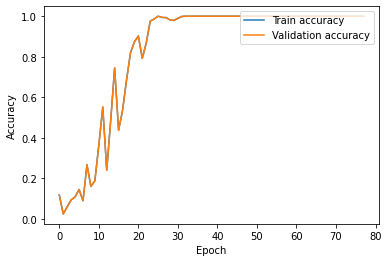

** Setting up network **
-- Setting up base station --
-- Done --
-- Setting up sensors data --
-- Done --
-- Setting up charging locations --
-- Done --
-- Initializing matrices --
-- Done --
-- Calculating matrices --
-- Done --
** Network is ready **


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 000, Loss: 3.83937, Train Acc: 0.08450, Test Acc: 0.08450
Epoch: 001, Loss: 5.60671, Train Acc: 0.03271, Test Acc: 0.03271
Epoch: 002, Loss: 5.37705, Train Acc: 0.03964, Test Acc: 0.03964
Epoch: 003, Loss: 3.88155, Train Acc: 0.15533, Test Acc: 0.15533
Epoch: 004, Loss: 4.11375, Train Acc: 0.07319, Test Acc: 0.07319
Epoch: 005, Loss: 3.98298, Train Acc: 0.08494, Test Acc: 0.08494
Epoch: 006, Loss: 3.81059, Train Acc: 0.19843, Test Acc: 0.19843
Epoch: 007, Loss: 3.76472, Train Acc: 0.28465, Test Acc: 0.28465
Epoch: 008, Loss: 3.72245, Train Acc: 0.22318, Test Acc: 0.22318
Epoch: 009, Loss: 3.44226, Train Acc: 0.08293, Test Acc: 0.08293
Epoch: 010, Loss: 3.29746, Train Acc: 0.46801, Test Acc: 0.46801
Epoch: 011, Loss: 3.19010, Train Acc: 0.35386, Test Acc: 0.35386
Epoch: 012, Loss: 3.09376, Train Acc: 0.33141, Test Acc: 0.33141
Epoch: 013, Loss: 2.94224, Train Acc: 0.65721, Test Acc: 0.65721
Epoch: 014, Loss: 2.79573, Train Acc: 0.64542, Test Acc: 0.64542
Epoch: 015, Loss: 2.66936

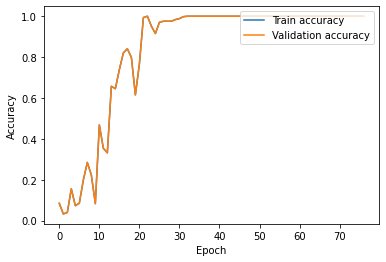

** Setting up network **
-- Setting up base station --
-- Done --
-- Setting up sensors data --
-- Done --
-- Setting up charging locations --
-- Done --
-- Initializing matrices --
-- Done --
-- Calculating matrices --
-- Done --
** Network is ready **


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 000, Loss: 3.86930, Train Acc: 0.10599, Test Acc: 0.10599
Epoch: 001, Loss: 5.50754, Train Acc: 0.04878, Test Acc: 0.04878
Epoch: 002, Loss: 5.57054, Train Acc: 0.13535, Test Acc: 0.13535
Epoch: 003, Loss: 4.01347, Train Acc: 0.17214, Test Acc: 0.17214
Epoch: 004, Loss: 4.31056, Train Acc: 0.07316, Test Acc: 0.07316
Epoch: 005, Loss: 4.24300, Train Acc: 0.07348, Test Acc: 0.07348
Epoch: 006, Loss: 4.05305, Train Acc: 0.19304, Test Acc: 0.19304
Epoch: 007, Loss: 3.84932, Train Acc: 0.16893, Test Acc: 0.16893
Epoch: 008, Loss: 3.68112, Train Acc: 0.07251, Test Acc: 0.07251
Epoch: 009, Loss: 3.58285, Train Acc: 0.19435, Test Acc: 0.19435
Epoch: 010, Loss: 3.43555, Train Acc: 0.38487, Test Acc: 0.38487
Epoch: 011, Loss: 3.20198, Train Acc: 0.55313, Test Acc: 0.55313
Epoch: 012, Loss: 3.01096, Train Acc: 0.51468, Test Acc: 0.51468
Epoch: 013, Loss: 2.87913, Train Acc: 0.33696, Test Acc: 0.33696
Epoch: 014, Loss: 2.83553, Train Acc: 0.39187, Test Acc: 0.39187
Epoch: 015, Loss: 2.67106

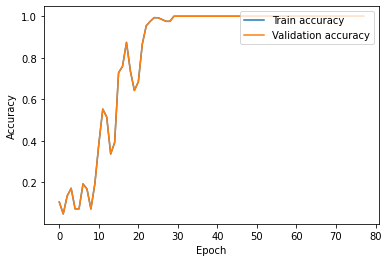

** Setting up network **
-- Setting up base station --
-- Done --
-- Setting up sensors data --
-- Done --
-- Setting up charging locations --
-- Done --
-- Initializing matrices --
-- Done --
-- Calculating matrices --
-- Done --
** Network is ready **


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 000, Loss: 3.87495, Train Acc: 0.07343, Test Acc: 0.07343
Epoch: 001, Loss: 5.47705, Train Acc: 0.06102, Test Acc: 0.06102
Epoch: 002, Loss: 5.60401, Train Acc: 0.12889, Test Acc: 0.12889
Epoch: 003, Loss: 4.03640, Train Acc: 0.19716, Test Acc: 0.19716
Epoch: 004, Loss: 4.27439, Train Acc: 0.07317, Test Acc: 0.07317
Epoch: 005, Loss: 4.07412, Train Acc: 0.12155, Test Acc: 0.12155
Epoch: 006, Loss: 3.92858, Train Acc: 0.17694, Test Acc: 0.17694
Epoch: 007, Loss: 3.84276, Train Acc: 0.19107, Test Acc: 0.19107
Epoch: 008, Loss: 3.89940, Train Acc: 0.23673, Test Acc: 0.23673
Epoch: 009, Loss: 3.65507, Train Acc: 0.22801, Test Acc: 0.22801
Epoch: 010, Loss: 3.31813, Train Acc: 0.29488, Test Acc: 0.29488
Epoch: 011, Loss: 3.17180, Train Acc: 0.46734, Test Acc: 0.46734
Epoch: 012, Loss: 3.09526, Train Acc: 0.33131, Test Acc: 0.33131
Epoch: 013, Loss: 2.97077, Train Acc: 0.48078, Test Acc: 0.48078
Epoch: 014, Loss: 2.74063, Train Acc: 0.67781, Test Acc: 0.67781
Epoch: 015, Loss: 2.54706

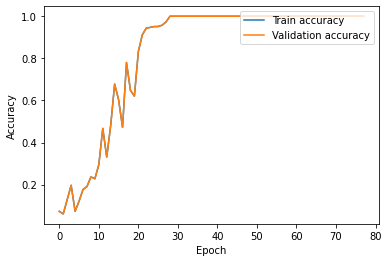

** Setting up network **
-- Setting up base station --
-- Done --
-- Setting up sensors data --
-- Done --
-- Setting up charging locations --
-- Done --
-- Initializing matrices --
-- Done --
-- Calculating matrices --
-- Done --
** Network is ready **


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 000, Loss: 3.89819, Train Acc: 0.05686, Test Acc: 0.05686
Epoch: 001, Loss: 5.33129, Train Acc: 0.03530, Test Acc: 0.03530
Epoch: 002, Loss: 5.60136, Train Acc: 0.06631, Test Acc: 0.06631
Epoch: 003, Loss: 3.99808, Train Acc: 0.09890, Test Acc: 0.09890
Epoch: 004, Loss: 4.06133, Train Acc: 0.13295, Test Acc: 0.13295
Epoch: 005, Loss: 4.13263, Train Acc: 0.07320, Test Acc: 0.07320
Epoch: 006, Loss: 4.12343, Train Acc: 0.25608, Test Acc: 0.25608
Epoch: 007, Loss: 3.95224, Train Acc: 0.07582, Test Acc: 0.07582
Epoch: 008, Loss: 3.81521, Train Acc: 0.14655, Test Acc: 0.14655
Epoch: 009, Loss: 3.53130, Train Acc: 0.13007, Test Acc: 0.13007
Epoch: 010, Loss: 3.25619, Train Acc: 0.18970, Test Acc: 0.18970
Epoch: 011, Loss: 3.20583, Train Acc: 0.41656, Test Acc: 0.41656
Epoch: 012, Loss: 3.05118, Train Acc: 0.47225, Test Acc: 0.47225
Epoch: 013, Loss: 2.94857, Train Acc: 0.48355, Test Acc: 0.48355
Epoch: 014, Loss: 2.83441, Train Acc: 0.70473, Test Acc: 0.70473
Epoch: 015, Loss: 2.66141

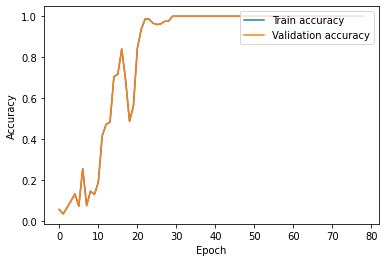

In [ ]:
from os import listdir
from os.path import isfile, join
import time

# Define paths
path_f = '/content/drive/MyDrive/2842022/dataset_{}/simulate'
load_path_f = '/content/drive/MyDrive/2842022/result/scenario-6/dataset_{}/GSADQL/state-graph'
state_load_time_path_f = '/content/drive/MyDrive/2842022/result/scenario-6/dataset_{}/GSADQL/state-graph'

nodes = [200]
DELTA_RANGES = [20, 40, 60, 80, 100]

for node in nodes:
  path = path_f.format(str(node))
  load_path = load_path_f.format(str(node))
  state_load_time_path = state_load_time_path_f.format(str(node))
  # only_files = [f for f in listdir(path) if isfile(join(path, f))]
  only_files = ['7.txt']
  for file in only_files:
    for delta in DELTA_RANGES:
      DELTA = delta
      try:
        start = time.time()
        m = node // 5
        env = TrainingEnvironment(path + '/' + file, m, 250, 250)

        # Modify state stored file
        state_file = "DELTA-{}-".format(delta) + file[:-4] + ".pkl"
        graph = Graph(env.network, train=True, file_path=load_path + '/' + state_file)
        graph.save_model(load_path + '/' + state_file)

        end = time.time()
        with open(state_load_time_path + '/' + file, 'a+') as f:
          f.writelines("Running time: {}".format(str(end-start)))
      except Exception:
        print("Error at main script")
        raise


Script for running RL model

In [ ]:
from os import listdir
from os.path import isfile, join
import time

# Define scenario
scenario = 6

# Define paths
path_f = '/content/drive/MyDrive/2842022/dataset_{}/simulate'
load_path_f = '/content/drive/MyDrive/2842022/result/scenario-6/dataset_{}/GSADQL/state-graph'
scenario_result_path_f = '/content/drive/MyDrive/2842022/result/scenario-' + str(scenario) + '/dataset_{}/GSADQL'
scenario_time_path_f = '/content/drive/MyDrive/2842022/result/scenario-' + str(scenario) + '/dataset_{}/GSADQL/running-time'


DELTA_RANGES = [20, 40, 60, 80, 100]
nodes = [200]
running_time = []

RUN = 20

for node in nodes:
  path = path_f.format(str(node))
  load_path = load_path_f.format(str(node))
  scenario_result_path = scenario_result_path_f.format(str(node))
  scenario_time_path = scenario_time_path_f.format(str(node))
  
  # only_files = [f for f in listdir(path) if isfile(join(path, f))]
  only_files = ['7.txt']
  for file in only_files:
    start = time.time()
    for delta in DELTA_RANGES:
      for run in range(RUN):
        DELTA = delta
        try:
          m = node // 5
          print(path + '/' + file)
          env = TrainingEnvironment(path + '/' + file, m, 250, 250)
          
          # Modify load state file
          state_file = "DELTA-{}-".format(delta) + file[:-4] + ".pkl"
          if run == 0:
            env.retrive_state_graph(load_path + '/' + state_file)
          
          env.drive(500)
        except Exception as e:
          print("Error at main script: {}".format(e))
          pass
  
        finally:
          # Modify result file
          res_file = "DELTA-{}-".format(delta) + file
          with open(scenario_result_path + '/' + res_file, 'a+') as f:
            f.writelines("Run{}: {}\n".format(run, RECORDED_DEAD_NODES))
    
      end = time.time()
      with open(scenario_time_path + '/' + res_file, 'w+') as f:
        f.writelines("Running time: {}".format(str(end-start)))
        running_time.append(end-start)


/content/drive/MyDrive/2842022/dataset_200/simulate/7.txt
** Setting up network **
-- Setting up base station --
-- Done --
-- Setting up sensors data --
-- Done --
-- Setting up charging locations --
-- Done --
-- Initializing matrices --
-- Done --
-- Calculating matrices --
-- Done --
** Network is ready **


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Streaming output truncated to the last 5000 lines.

++ Charging time spent at 27 is 326.07067763198785 ++
++ Energy left of MC is 98823.65803391403 ++

++ Charging time spent at 29 is 170.04444434171802 ++
++ Energy left of MC is 97649.81914288041 ++

++ Charging time spent at 28 is 1230.8383038420625 ++
++ Energy left of MC is 96854.47503655587 ++

++ Charging time spent at 29 is 50 ++
++ Energy left of MC is 92533.2833408781 ++

++ Charging time spent at 30 is 227.42850879393035 ++
++ Energy left of MC is 92159.87053822256 ++

++ Charging time spent at 25 is 52.658519073013395 ++
++ Energy left of MC is 91432.0919633716 ++

++ Charging time spent at 24 is 68.29125536103398 ++
++ Energy left of MC is 91024.9239608627 ++

++ Charging time spent at 26 is 513.4265006967973 ++
++ Energy left of MC is 90378.31943232022 ++

++ Charging time spent at 27 is 50 ++
++ Energy left of MC is 88067.3464413569 ++

++ Charging time spent at 31 is 50 ++
++ Energy left of MC is 87702.92098830114 ++

++

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Streaming output truncated to the last 5000 lines.

++ Charging time spent at 6 is 50 ++
++ Energy left of MC is 106627.04414067978 ++

++ Charging time spent at 6 is 50 ++
++ Energy left of MC is 106143.29823646725 ++

++ Charging time spent at 7 is 76.34147298413457 ++
++ Energy left of MC is 106143.29823646725 ++

++ Charging time spent at 15 is 157.62418898652177 ++
++ Energy left of MC is 105469.07559062465 ++

++ Charging time spent at 8 is 379.037164913856 ++
++ Energy left of MC is 104648.62351577131 ++

++ Charging time spent at 10 is 80.99346872233697 ++
++ Energy left of MC is 102755.27838777356 ++

++ Charging time spent at 14 is 100.44300704485433 ++
++ Energy left of MC is 102283.29852769493 ++

++ Charging time spent at 3 is 101.27540416198948 ++
++ Energy left of MC is 101461.10165451204 ++

++ Charging time spent at 20 is 469.53703948672745 ++
++ Energy left of MC is 100597.74649210497 ++

++ Charging time spent at 10 is 50 ++
++ Energy left of MC is 99259.60181482793 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Streaming output truncated to the last 5000 lines.
++ Energy left of MC is 107439.11858669223 ++

++ Charging time spent at 31 is 91.46824510181415 ++
++ Energy left of MC is 107119.34766659165 ++

++ Charging time spent at 30 is 2206.856214379587 ++
++ Energy left of MC is 106284.06771394005 ++

++ Charging time spent at 28 is 915.0634467919028 ++
++ Energy left of MC is 100277.93178179 ++

++ Charging time spent at 29 is 135.90662921688406 ++
++ Energy left of MC is 97075.45195779599 ++

++ Charging time spent at 25 is 112.87848854823254 ++
++ Energy left of MC is 96352.6700802794 ++

++ Charging time spent at 24 is 122.52533206440408 ++
++ Energy left of MC is 95825.00326142179 ++

++ Charging time spent at 26 is 388.610229022161 ++
++ Energy left of MC is 94960.78739495318 ++

++ Charging time spent at 27 is 276.6791169271743 ++
++ Energy left of MC is 93178.556376311 ++

++ Charging time spent at 19 is 1652.2517072647308 ++
++ Energy left of MC is 92091.07823768894 ++

++ Charging

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Streaming output truncated to the last 5000 lines.

++ Charging time spent at 16 is 50 ++
++ Energy left of MC is 107452.29639854353 ++

++ Charging time spent at 6 is 50 ++
++ Energy left of MC is 107027.2238307043 ++

++ Charging time spent at 23 is 50 ++
++ Energy left of MC is 106537.97070774014 ++

++ Charging time spent at 15 is 147.01245187342002 ++
++ Energy left of MC is 105965.50540431734 ++

++ Charging time spent at 29 is 50 ++
++ Energy left of MC is 105226.06916211304 ++

++ Charging time spent at 38 is 50 ++
++ Energy left of MC is 104833.87702707284 ++

++ Charging time spent at 29 is 50 ++
++ Energy left of MC is 104691.3317203809 ++

++ Charging time spent at 5 is 50 ++
++ Energy left of MC is 104614.52400185695 ++

++ Charging time spent at 13 is 50 ++
++ Energy left of MC is 104002.20680249858 ++

++ Charging time spent at 9 is 50 ++
++ Energy left of MC is 103672.1843092772 ++

++ Charging time spent at 10 is 80.78998857706236 ++
++ Energy left of MC is 103211.5674

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Streaming output truncated to the last 5000 lines.
++ Charging time spent at 0 is 1036.0621406593357 ++
++ Energy left of MC is 49067.322181127565 ++

++ Charging time spent at 23 is 428.3923221658694 ++
++ Energy left of MC is 45722.18960896206 ++

++ Charging time spent at 7 is 707.2183160814077 ++
++ Energy left of MC is 44048.08216186429 ++

++ Charging time spent at 23 is 50 ++
++ Energy left of MC is 41282.03689918526 ++

++ Charging time spent at 6 is 196.2364915695029 ++
++ Energy left of MC is 41034.55836561028 ++

++ Charging time spent at 4 is 210.20791157019448 ++
++ Energy left of MC is 40106.58375359352 ++

++ Charging time spent at 5 is 395.5361720844064 ++
++ Energy left of MC is 38969.803551003126 ++

++ Charging time spent at 1 is 837.563093163418 ++
++ Energy left of MC is 37484.64570256462 ++

++ Charging time spent at 16 is 69.82452485729358 ++
++ Energy left of MC is 33773.66552615488 ++

++ Charging time spent at 2 is 976.1371981228395 ++
++ Energy left of MC is 